In [8]:
from osgeo import gdal, osr
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
plt.style.use('ggplot')

In [85]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
import geopandas as gpd
import fiona

In [148]:
gauge_rmse= 'TCresults/nonHarvey/rmse_gauge_mtc.tif'
satellite_rmse= 'TCresults/nonHarvey/rmse_sat_mtc.tif'
radar_rmse= 'TCresults/nonHarvey/rmse_radar_mtc.tif'

gauge_satellite_mae= 'intercomparison/nonHarvey/gauge_satellite_mae.tif'
radar_satellite_mae= 'intercomparison/nonHarvey/radar_satellite_mae.tif'
gauge_radar_mae= 'intercomparison/nonHarvey/gauge_radar_mae.tif'

gauge_satellite_rmse= 'intercomparison/nonHarvey/gauge_satellite_rmse.tif'
radar_satellite_rmse= 'intercomparison/nonHarvey/radar_satellite_rmse.tif'
gauge_radar_rmse= 'intercomparison/nonHarvey/gauge_radar_rmse.tif'

gauge_cc= 'TCresults/nonHarvey/cc_gauge_mtc.tif'
satellite_cc= 'TCresults/nonHarvey/cc_sat_mtc.tif'
radar_cc= 'TCresults/nonHarvey/cc_radar_mtc.tif'

gauge_satellite_cc= 'intercomparison/nonHarvey/gauge_satellite_r.tif'
radar_satellite_cc= 'intercomparison/nonHarvey/radar_satellite_r.tif'
gauge_radar_cc= 'intercomparison/nonHarvey/gauge_radar_r.tif'

gauge_sum= 'intercomparison/nonHarvey/gauge_satellite_sum_gauge.tif'
radar_sum= 'intercomparison/nonHarvey/gauge_radar_sum_radar.tif'
sat_sum= 'intercomparison/nonHarvey/gauge_satellite_sum_satellite.tif'

gauge_extreme= 'intercomparison/nonHarvey/gauge_satellite_extreme_gauge.tif'
radar_extreme= 'intercomparison/nonHarvey/gauge_radar_extreme_radar.tif'
sat_extreme= 'intercomparison/nonHarvey/gauge_satellite_extreme_satellite.tif'

zone_shp= '../harveyimpact/400mmzone.shp'
harveyimpact= '../harveyimpact/harveyimpact.shp'

cmap_data= ['white',"lightblue","blue", "green",
                        "greenyellow", "yellow","gold","orange", "darkorange",
                        "red", "darkred", "purple"]

In [149]:
def plot_mae(src):
    # Plotting 2070 projected August (8) precip from worldclim
    gdata = gdal.Open(src)
    geo = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(float)
    xres = geo[1]
    yres = geo[5]
    data[(data<0)]= np.nan
    avg= np.nanmean(data)
    mx= np.nanmax(data)
    mn= np.nanmin(data)
    data= mask_raster(src, harveyimpact)

    # A good LCC projection for USA plots
    m = Basemap(llcrnrlon=-101.5,llcrnrlat=25.7,urcrnrlon=-88.4,urcrnrlat=35.2,
                projection='cyl',lat_1=33,lat_2=45,lon_0=-95)

    # This just plots the shapefile -- it has already been clipped
    m.readshapefile('../harveyimpact/harveyimpact','harveyimpact',drawbounds=True, color='0.3')
    m.readshapefile('../harveyimpact/400mmzone','rain',drawbounds=True, color='0.2')
    xmin = geo[0] + xres * 0.5
    xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
    ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
    ymax = geo[3] - yres * 0.5

    x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    x,y = m(x,y)

    cmap = plt.get_cmap('rainbow')
    cmap.set_under ('1.0')
    cmap.set_bad('0.8')

    map = m.pcolormesh(x,y, data.T, cmap=cmap, vmin=0.1, vmax=5)

#     cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.7)

    return map, avg, mn, mx

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


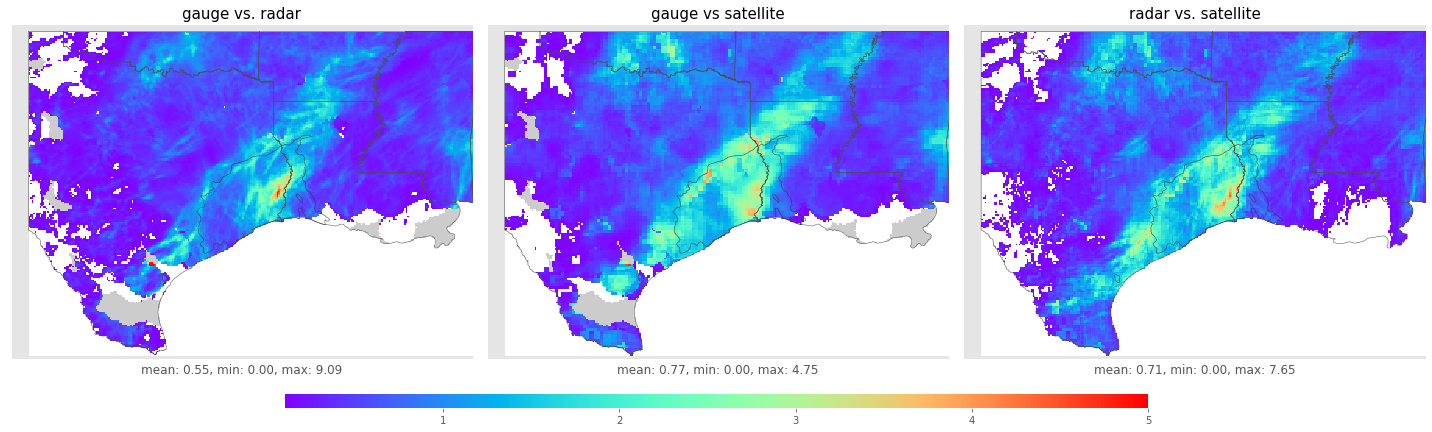

In [150]:
fig= plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,3,1)
ax.set_title("gauge vs. radar",fontsize=15)
map, avg, mn, mx = plot_mae(gauge_radar_mae)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(1,3,2)
ax.set_title("gauge vs satellite",fontsize=15)
map, avg, mn, mx = plot_mae(gauge_satellite_mae)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(1,3,3)
ax.set_title("radar vs. satellite",fontsize=15)
map, avg, mn, mx = plot_mae(radar_satellite_mae)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
cbar= fig.add_axes((0.2,0.2,.6,.02))
cb = plt.colorbar( orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
plt.tight_layout()
fig.savefig('mae_comparison_nonHarvey.png', dpi=144)

In [104]:
def mask_raster(raster_name, shapes_name, crop=False):
    raster= rasterio.open(raster_name)
    with fiona.open(harveyimpact, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    
    out_img, out_transform = mask(raster, shapes, crop=False)
    
    return out_img.squeeze()

In [108]:
mx_radar= gdal.Open(radar_sum).ReadAsArray().max()

def plot_amt(src):

    gdata = gdal.Open(src)
    geo = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(float)
    xres = geo[1]
    yres = geo[5]
    data[(data<0)]= np.nan
    avg= np.nanmean(data)
    mx= np.nanmax(data)
    mn= np.nanmin(data)
    data= mask_raster(src, harveyimpact)

    # A good LCC projection for USA plots
    m = Basemap(llcrnrlon=-101.5,llcrnrlat=25.7,urcrnrlon=-88.4,urcrnrlat=35.2,
                projection='cyl',lat_1=33,lat_2=45,lon_0=-95,ellps = 'WGS84')

    # This just plots the shapefile -- it has already been clipped
    m.readshapefile('../harveyimpact/harveyimpact','harveyimpact',drawbounds=True, color='0.1')
    m.readshapefile('../harveyimpact/400mmzone','rain',drawbounds=True, color='0.2')
#     m.drawparallels(parallels,labels=[False,True,True,False])
    xmin = geo[0] + xres * 0.5
    xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
    ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
    ymax = geo[3] - yres * 0.5

    x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    x,y = m(x,y)
    parallels = np.arange(-100,-90,5.)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,True,True,True])
    meridians = np.arange(30.,34.,2.)
    m.drawmeridians(meridians,labels=[True,True,True,True])
#     cmap = plt.get_cmap(cmap)
#     cmap.set_under ('1.0')
#     cmap.set_bad('0.8')
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    map = m.pcolormesh(x,y, data.T, cmap=cmap, vmin=0, vmax=mx_radar)

#     cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.5)

    return map, avg, mn, mx

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


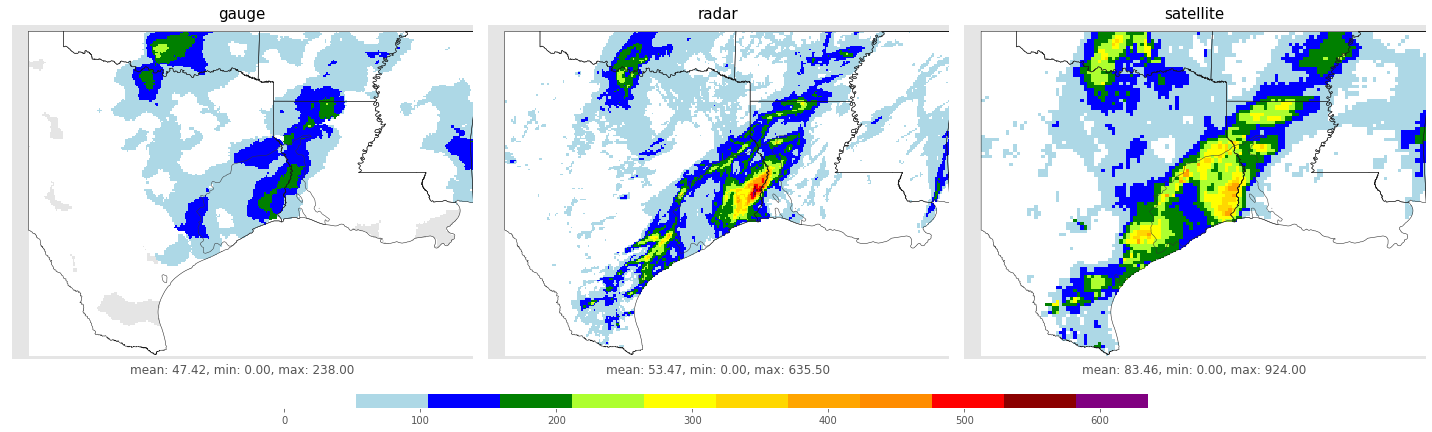

In [120]:
fig= plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,3,1)
ax.set_title("gauge",fontsize=15)
map_1, avg, mn, mx = plot_amt(gauge_sum)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(1,3,2)
ax.set_title("radar",fontsize=15)
map_2, avg, mn_radar, mx_radar = plot_amt(radar_sum)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn_radar, mx_radar))

ax = fig.add_subplot(1,3,3)
ax.set_title("satellite",fontsize=15)
map_3, avg, mn, mx = plot_amt(sat_sum)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

cbar= fig.add_axes((0.2,0.2,.6,.02))
# cbar.ax.text(range(0.2,0.6,0.4/len(cmap_data)),.1 / 8.0, range(0,mx_radar,mx_radar/len(cmap_data)), ha='center', va='center')

# fig.tight_layout()
fig.colorbar( orientation='horizontal', mappable=map_2, cax= cbar, shrink=0.5, fraction=0.5)
fig.tight_layout()
fig.savefig('total_nonHarvey.png', dpi=144)

In [117]:
mx_radar= gdal.Open(radar_extreme).ReadAsArray().max()

def plot_amt(src):

    gdata = gdal.Open(src)
    geo = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(float)
    xres = geo[1]
    yres = geo[5]
    data[(data<0)]= np.nan
    avg= np.nanmean(data)
    mx= np.nanmax(data)
    mn= np.nanmin(data)
    data= mask_raster(src, harveyimpact)

    # A good LCC projection for USA plots
    m = Basemap(llcrnrlon=-101.5,llcrnrlat=25.7,urcrnrlon=-88.4,urcrnrlat=35.2,
                projection='cyl',lat_1=33,lat_2=45,lon_0=-95,ellps = 'WGS84')

    # This just plots the shapefile -- it has already been clipped
    m.readshapefile('../harveyimpact/harveyimpact','harveyimpact',drawbounds=True, color='0.1')
    m.readshapefile('../harveyimpact/400mmzone','rain',drawbounds=True, color='0.2')
#     m.drawparallels(parallels,labels=[False,True,True,False])
    xmin = geo[0] + xres * 0.5
    xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
    ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
    ymax = geo[3] - yres * 0.5

    x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    x,y = m(x,y)
    parallels = np.arange(-100,-90,5.)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,True,True,True])
    meridians = np.arange(30.,34.,2.)
    m.drawmeridians(meridians,labels=[True,True,True,True])
#     cmap = plt.get_cmap(cmap)
#     cmap.set_under ('1.0')
#     cmap.set_bad('0.8')
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    map = m.pcolormesh(x,y, data.T, cmap=cmap, vmin=0, vmax=mx_radar)

#     cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.5)

    return map, avg, mn, mx

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


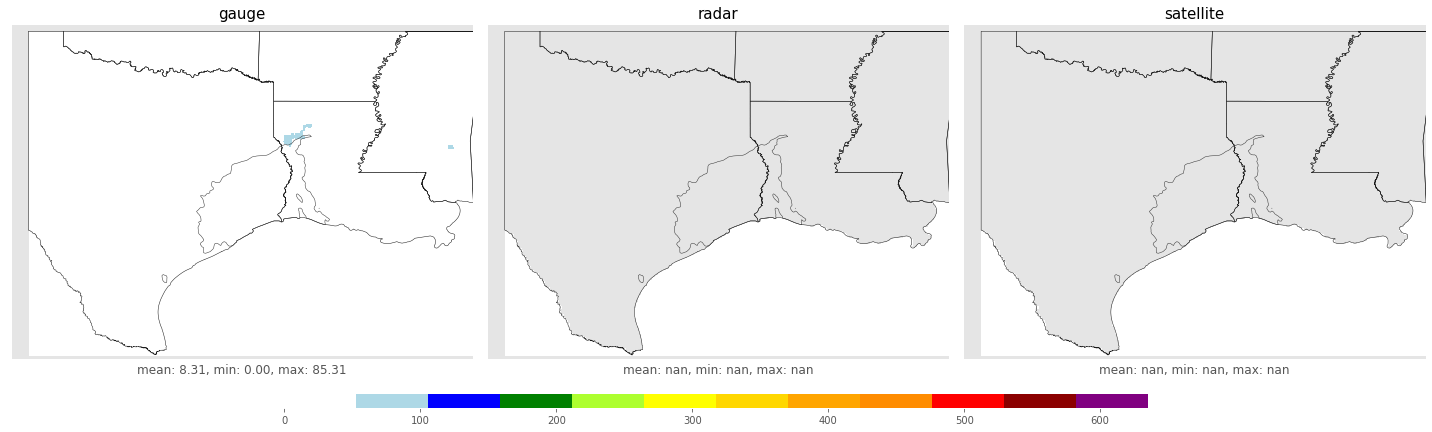

In [125]:
fig= plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,3,1)
ax.set_title("gauge",fontsize=15)
map_1, avg, mn, mx = plot_amt(gauge_extreme)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(1,3,2)
ax.set_title("radar",fontsize=15)
map_2, avg, mn_radar, mx_radar = plot_amt(radar_extreme)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn_radar, mx_radar))

ax = fig.add_subplot(1,3,3)
ax.set_title("satellite",fontsize=15)
map_3, avg, mn, mx = plot_amt(sat_extreme)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

cbar= fig.add_axes((0.2,0.2,.6,.02))
# cbar.ax.text(range(0.2,0.6,0.4/len(cmap_data)),.1 / 8.0, range(0,mx_radar,mx_radar/len(cmap_data)), ha='center', va='center')

# fig.tight_layout()
fig.colorbar( orientation='horizontal', mappable=map_2, cax= cbar, shrink=0.5, fraction=0.5)
fig.tight_layout()
# fig.savefig('total_comparison.png', dpi=144)

In [135]:
def plot(src):
    # Plotting 2070 projected August (8) precip from worldclim
    gdata = gdal.Open(src)
    geo = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(float)
    xres = geo[1]
    yres = geo[5]
    data[(data<0)]= np.nan
    avg= np.nanmean(data)
    mx= np.nanmax(data)
    mn= np.nanmin(data)
    data= mask_raster(src, harveyimpact)

    # A good LCC projection for USA plots
    m = Basemap(llcrnrlon=-101.5,llcrnrlat=25.7,urcrnrlon=-88.4,urcrnrlat=35.2,
                projection='cyl',lat_1=33,lat_2=45,lon_0=-95)

    # This just plots the shapefile -- it has already been clipped
    m.readshapefile('../harveyimpact/harveyimpact','harveyimpact',drawbounds=True, color='0.3')
    m.readshapefile('../harveyimpact/400mmzone','rain',drawbounds=True, color='0.2')
    xmin = geo[0] + xres * 0.5
    xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
    ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
    ymax = geo[3] - yres * 0.5

    x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    x,y = m(x,y)

    cmap = plt.get_cmap('rainbow')
    cmap.set_under ('1.0')
    cmap.set_bad('0.8')

    map = m.pcolormesh(x,y, data.T, cmap=cmap, vmin=0.1, vmax=5)

    cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.7)

    return map, avg, mn, mx

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


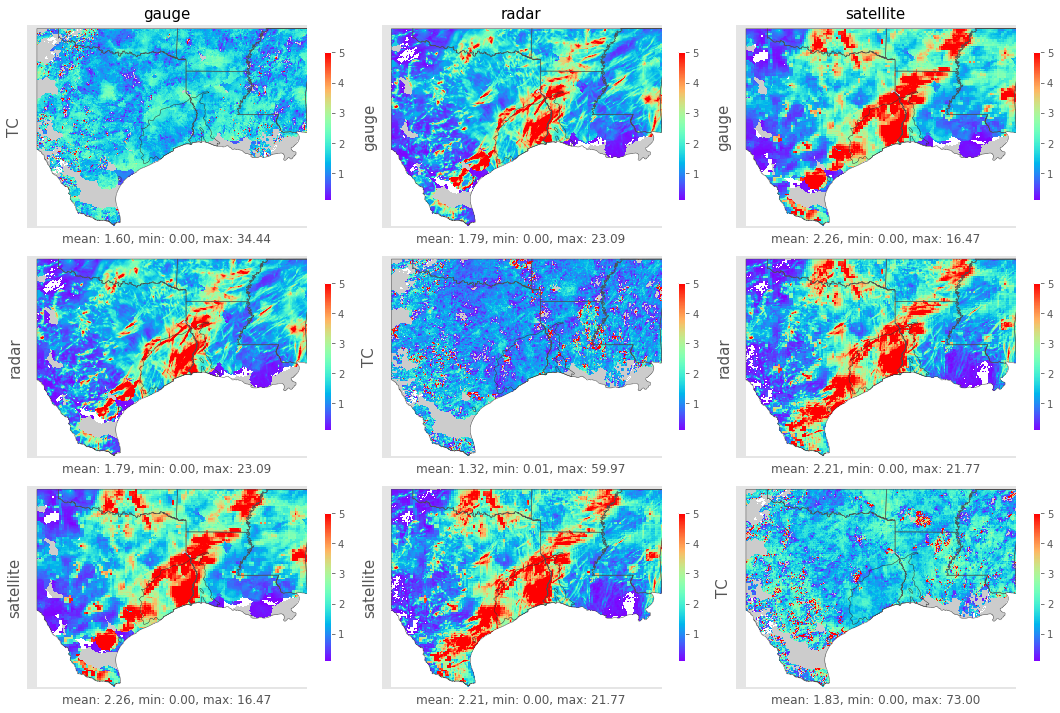

In [136]:
# normalized
fig= plt.figure(figsize=(15,10))

ax = fig.add_subplot(3,3,1)
ax.set_title("gauge",fontsize=15)
map, avg, mn, mx = plot(gauge_rmse)
ax.set_ylabel('TC',fontsize=15)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(3,3,2)
ax.set_title("radar",fontsize=15)
map, avg, mn, mx = plot(gauge_radar_rmse)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('gauge',fontsize=15)

ax = fig.add_subplot(3,3,3)
ax.set_title("satellite",fontsize=15)
map, avg, mn, mx = plot(gauge_satellite_rmse)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('gauge',fontsize=15)

ax = fig.add_subplot(3,3,4)
map, avg, mn, mx = plot(gauge_radar_rmse)
ax.set_ylabel('radar',fontsize=15)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(3,3,5)

map, avg, mn, mx = plot(radar_rmse)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('TC',fontsize=15)

ax = fig.add_subplot(3,3,6)

map, avg, mn, mx = plot(radar_satellite_rmse)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('radar',fontsize=15)

ax = fig.add_subplot(3,3,7)
ax.set_ylabel('satellite',fontsize=15)
map, avg, mn, mx = plot(gauge_satellite_rmse)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(3,3,8)

map, avg, mn, mx = plot(radar_satellite_rmse)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('satellite',fontsize=15)

ax = fig.add_subplot(3,3,9)

map, avg, mn, mx = plot(satellite_rmse)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('TC',fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('rmse_comparison_nonHarvey.png', dpi=144)

In [140]:
def plot_cc(src):
    # Plotting 2070 projected August (8) precip from worldclim
    gdata = gdal.Open(src)
    geo = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(float)
    xres = geo[1]
    yres = geo[5]
    data[(data<0)]= np.nan
    avg= np.nanmean(data)
    mx= np.nanmax(data)
    mn= np.nanmin(data)
    data= mask_raster(src, harveyimpact)

    # A good LCC projection for USA plots
    m = Basemap(llcrnrlon=-101.5,llcrnrlat=25.7,urcrnrlon=-88.4,urcrnrlat=35.2,
                projection='cyl',lat_1=33,lat_2=45,lon_0=-95)

    # This just plots the shapefile -- it has already been clipped
    m.readshapefile('../harveyimpact/harveyimpact','harveyimpact',drawbounds=True, color='0.3')
    m.readshapefile('../harveyimpact/400mmzone','rain',drawbounds=True, color='0.2')
    xmin = geo[0] + xres * 0.5
    xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
    ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
    ymax = geo[3] - yres * 0.5

    x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    x,y = m(x,y)

    cmap = plt.get_cmap('rainbow')
    cmap.set_under ('1.0')
    cmap.set_bad('0.8')

    map = m.pcolormesh(x,y, data.T, cmap=cmap, vmin=0.1, vmax=1)

    cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.7)

    return map, avg, mn, mx

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


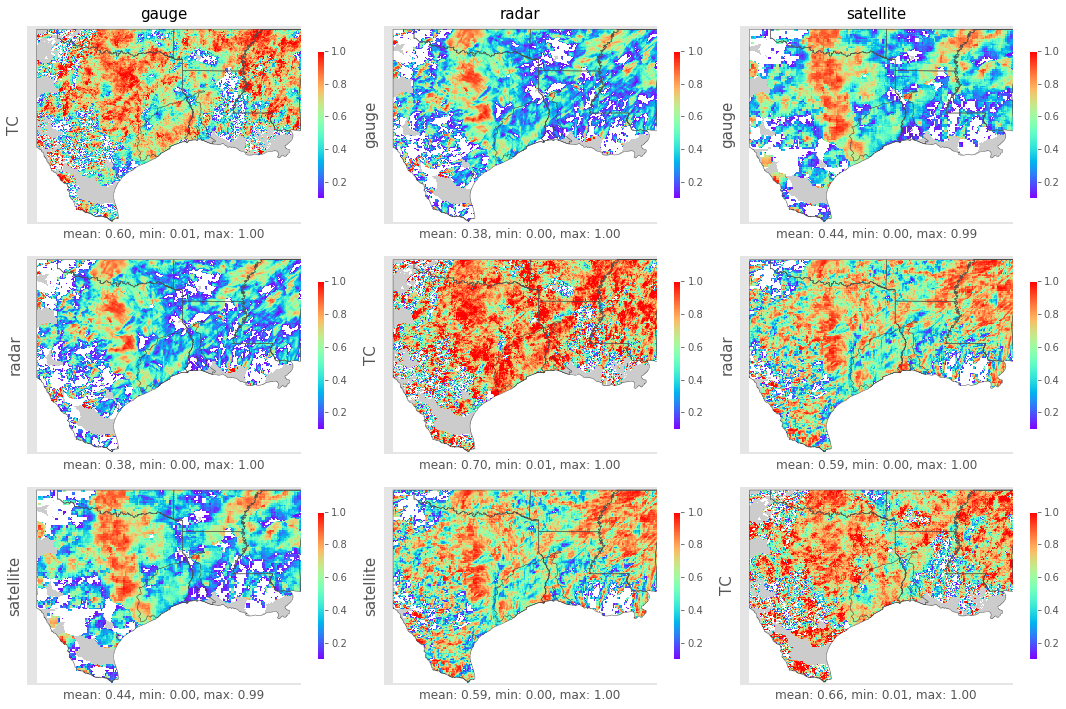

In [141]:
fig= plt.figure(figsize=(15,10))

ax = fig.add_subplot(3,3,1)
ax.set_title("gauge",fontsize=15)
map, avg, mn, mx = plot_cc(gauge_cc)
ax.set_ylabel('TC',fontsize=15)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(3,3,2)
ax.set_title("radar",fontsize=15)
map, avg, mn, mx = plot_cc(gauge_radar_cc)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('gauge',fontsize=15)

ax = fig.add_subplot(3,3,3)
ax.set_title("satellite",fontsize=15)
map, avg, mn, mx = plot_cc(gauge_satellite_cc)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('gauge',fontsize=15)

ax = fig.add_subplot(3,3,4)
map, avg, mn, mx = plot_cc(gauge_radar_cc)
ax.set_ylabel('radar',fontsize=15)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(3,3,5)

map, avg, mn, mx = plot_cc(radar_cc)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('TC',fontsize=15)

ax = fig.add_subplot(3,3,6)

map, avg, mn, mx = plot_cc(radar_satellite_cc)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('radar',fontsize=15)

ax = fig.add_subplot(3,3,7)
ax.set_ylabel('satellite',fontsize=15)
map, avg, mn, mx = plot_cc(gauge_satellite_cc)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))

ax = fig.add_subplot(3,3,8)

map, avg, mn, mx = plot_cc(radar_satellite_cc)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('satellite',fontsize=15)

ax = fig.add_subplot(3,3,9)

map, avg, mn, mx = plot_cc(satellite_cc)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx))
ax.set_ylabel('TC',fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('cc_comparison_nonHarvey.png', dpi=144)